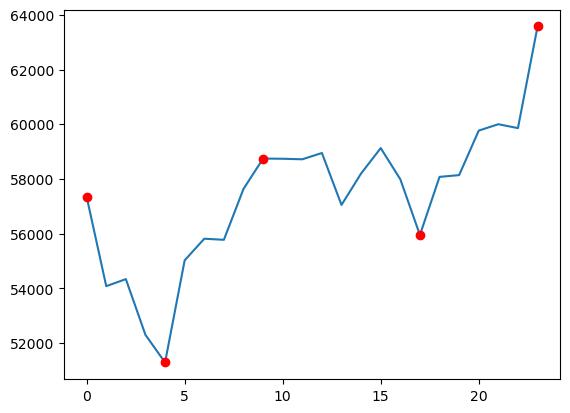

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):
            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpendicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y


if __name__ == "__main__":
    data = pd.read_csv('BTCUSDT86400.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')

    n_perc_points = 5
    n_close_points = 24
    i = 1198
    x = data['close'].iloc[i-n_close_points:i].to_numpy()
    pips_x, pips_y = find_pips(x, n_perc_points, 2)

    pd.Series(x).plot()
    for i in range(n_perc_points):
        plt.plot(pips_x[i], pips_y[i], marker='o', color='red')

    plt.show()